In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import random as rnd
import csv
import random
import math
import operator
from pprint import pprint 

# Preprocess Dataset

In [11]:
train_data = pd.read_csv('train3.csv')
# median_LotFrontage = train_data.LotFrontage.median()
train_data = train_data.drop(["Id","LotFrontage","Alley","MasVnrType","MasVnrArea","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature","GarageType"],axis=1)
train_data = train_data.rename(columns={"SalePrice":"label"})
test_df = pd.read_csv('test3.csv')
test_df = test_df.drop(["Id","LotFrontage","Alley","MasVnrType","MasVnrArea","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature","GarageType"],axis=1)
test_label_df = pd.read_csv('test_labels3.csv',header=None)
test_label_df = test_label_df.drop(0,axis=1)
test_label_df = test_label_df.rename(columns={1:"label"})

In [145]:
train_data

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,label
0,60,RL,12099,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,0,6,2007,WD,Normal,354000
1,20,RL,13214,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,...,0,0,0,0,0,5,2010,WD,Normal,378500
2,120,RM,4500,Pave,Reg,Lvl,AllPub,FR2,Gtl,Mitchel,...,0,0,0,0,0,3,2006,WD,Normal,153500
3,160,FV,3000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,0,0,0,0,0,6,2009,New,Partial,173733
4,20,RL,6897,Pave,IR1,Lvl,AllPub,Corner,Gtl,Sawyer,...,0,0,0,0,0,4,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,120,RL,6792,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,0,3,2006,New,Partial,202665
996,30,RL,10625,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,...,77,0,0,0,400,5,2010,COD,Abnorml,83000
997,85,RL,9101,Pave,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,...,0,0,0,0,0,7,2009,WD,Normal,165500
998,20,RL,13125,Pave,Reg,Lvl,AllPub,Inside,Mod,CollgCr,...,0,0,0,0,0,4,2008,WD,Normal,208900


# Scikit Learn

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
clf = DecisionTreeClassifier()
train = train_data.values
for i in range(len(train)-1):
    if (isinstance(train[:,i][0],str)):
        le.fit(train[:,i])
X_train = train[:,1:]
Y_train = train[:,-1]
X_test = test_df.values
Y_test = test_label_df.values
clf = clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6753246753246753


# Baseline Algorithm

In [261]:
def No_Rule_Regression_Algorithm(train, test):
    output_values = [row[-1] for row in train]
    prediction = sum(output_values) / float(len(output_values))
    predicted = [prediction for i in range(len(test))]
    return predicted

In [262]:
def calculate_r_squared(actual,predicted):   
    labels = actual.label
    mean = labels.mean()
    ss_res = sum((labels - predicted) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    return r_squared

In [266]:
train = train_data.values
test = test_label_df.values
predicted = No_Rule_Regression_Algorithm(train, test)
calculate_r_squared(test_label_df,predicted)

-0.0071256473131195985

## Train-Validation split

In [234]:
def train_valid_split(train_data,valid_size):
    if isinstance(valid_size,float):
        valid_size=round(valid_size * len(train_data))
    indices = train_data.index.tolist()
    valid_indices = random.sample(population=indices,k=valid_size)
    valid_df = train_data.loc[valid_indices]
    train_df = train_data.drop(valid_indices)
    return train_df,valid_df

In [100]:
random.seed(0)
train_df,valid_df = train_valid_split(train_data,valid_size=0.3)

In [193]:
len(test_df.columns)

61

### Base Condition

In [102]:
def isdatapure(data):
    label_column = data[:,-1]
    unique_label = np.unique(label_column)
    if len(unique_label) == 1:
        return True
    else:
        return False

### Create Leaf Node

In [103]:
def create_leaf_node(data):
    label_column = data[:,-1]
    leaf = np.mean(label_column)
    return leaf

### Split points

In [104]:
def get_split_points(data):
    split_points = {}
    _,n_columns = data.shape
    for column_index in range(n_columns-1):
        column_values = data[:,column_index]
        unique_column_values = np.unique(column_values)
        split_points[column_index] = unique_column_values
    return split_points

### Split dataset

In [105]:
def split_dataset(data, split_column, split_value):
    split_column_values = data[:,split_column]
    feature_type = Feature_Types[split_column]
    if feature_type == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values > split_value]
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    return data_below, data_above

### Determine the best split point

In [106]:
def calculate_mse(data):
    actual_values = data[:,-1]
    if len(actual_values) == 0:
        mse=0
    else:
        predicted_values = np.mean(actual_values)
        mse = np.mean((actual_values - predicted_values) ** 2)
    return mse;

In [107]:
def calculate_overall_metric(data_below, data_above, metric_function):
    num_data_points = len(data_below) + len(data_above)
    prob_data_below = len(data_below)/num_data_points
    prob_data_above = len(data_above)/num_data_points
    overall_metric = (prob_data_below * metric_function(data_below)+ 
                      prob_data_above * metric_function(data_above))
    return overall_metric
    

In [108]:
def determine_best_split(data, split_points):
    First_iteration = True
    for column_index in split_points:
        for column_value in split_points[column_index]:
            data_below, data_above = split_dataset(data,split_column=column_index,split_value=column_value)
            
            current_overall_metric = calculate_overall_metric(data_below,data_above,metric_function=
                                                              calculate_mse)
            
            if First_iteration or current_overall_metric <= best_overall_metric:
                First_iteration = False
                best_split_column = column_index
                best_split_value = column_value
                best_overall_metric = current_overall_metric
    return best_split_column, best_split_value

# Decision Tree Algorithm

In [232]:
def determine_feature_type(df):
    feature_type = []
    for feature in df.columns:
        if feature != "label":
            unique_feature_values = df[feature].unique()
            feature_value = unique_feature_values[0]
            if (isinstance(feature_value,str)):
                feature_type.append("catagorical")
            else:
                feature_type.append("continuous")
    return feature_type

In [125]:
def Decision_Tree_algorithm(df,count=0,min_samples=2,max_depth=5):
    
    # Data Preparation 
    if count == 0:
        global Column_Headers,Feature_Types
        Column_Headers = df.columns
        Feature_Types = determine_feature_type(df)
        data = df.values
    else:
        data = df
    
    if (isdatapure(data)) or (len(data) < min_samples) or (count == max_depth):
        leaf = create_leaf_node(data)
        return leaf
    else:
        count += 1
        split_points = get_split_points(data)
        split_column, split_value = determine_best_split(data,split_points)
        data_below, data_above = split_dataset(data,split_column,split_value)
        
        if len(data_below)==0 or len(data_above)==0:
            leaf = create_leaf_node(data);
            return leaf
        feature_column = Column_Headers[split_column]
        feature_type = Feature_Types[split_column]
        if feature_type == "continuous":
            question = "{} <= {}".format(feature_column,split_value)
        else:
            question = "{} == {}".format(feature_column,split_value)
        
        sub_tree = {question:[]}
        
        yes_answer = Decision_Tree_algorithm(data_below,count,min_samples,max_depth)
        no_answer = Decision_Tree_algorithm(data_above,count,min_samples,max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        return sub_tree

In [131]:
tree = Decision_Tree_algorithm(train_df,max_depth=5)
pprint(tree)

{'OverallQual <= 7': [{'GrLivArea <= 1484': [{'YearBuilt <= 1984': [{'TotalBsmtSF <= 630': [{'GrLivArea <= 1092': [82862.70370370371,
                                                                                                                   109758.69565217392]},
                                                                                            {'1stFlrSF <= 1148': [127062.48,
                                                                                                                  151384.36923076923]}]},
                                                                    {'GrLivArea <= 1145': [{'GrLivArea <= 1072': [138166.66666666666,
                                                                                                                  155100.0]},
                                                                                           {'TotalBsmtSF <= 660': [162320.625,
                                                                               

In [158]:
def predict_house_price(example, tree):
    question = list(tree.keys())[0]
    feature_name, cmp, value = question.split(" ")
    if cmp == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [185]:
example = test_df.iloc[0]
actual_prices = test_label_df.values
actual_price = actual_prices[0]
predicted_price = predict_house_price(example,tree)
print(' actual_price=%d'%actual_price,'\n','predicted_price=%f'%predicted_price)

 actual_price=128000 
 predicted_price=127062.480000


# Hyperparameter Tunning

In [224]:
def calculate_r_squared(df, tree, Dataframe_type):   
    if Dataframe_type == "test":
        labels = test_label_df.label
    else:
        labels = df.label
    mean = labels.mean()
    predictions = df.apply(predict_example, args=(tree,), axis=1)

    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

In [195]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": []}
for max_depth in range(2, 11):
    for min_samples in range(5, 30, 5):
        tree = Decision_Tree_algorithm(train_df, min_samples=min_samples,max_depth=max_depth)
        
        r_squared_train = calculate_r_squared(train_df, tree, Dataframe_type="train")
        r_squared_val = calculate_r_squared(valid_df, tree, Dataframe_type="validation")
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()

,max_depth,min_samples,r_squared_train,r_squared_val
21,6,10,0.908435,0.622031
22,6,15,0.906610,0.620903
24,6,25,0.884775,0.619115
20,6,5,0.917297,0.614042
23,6,20,0.899531,0.610520


In [212]:
best_max_depth = 6
best_min_samples = 10

tree = Decision_Tree_algorithm(train_df, min_samples=best_min_samples, max_depth=best_max_depth)
calculate_r_squared(test_df, tree,"test")

0.6513664226575097

In [229]:
def create_plot(df, tree, title):    
    predictions = df.apply(predict_example, args=(tree,), axis=1)
    if title == "Test Data":
        actual = test_label_df.label
    else:
        actual = df.label
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

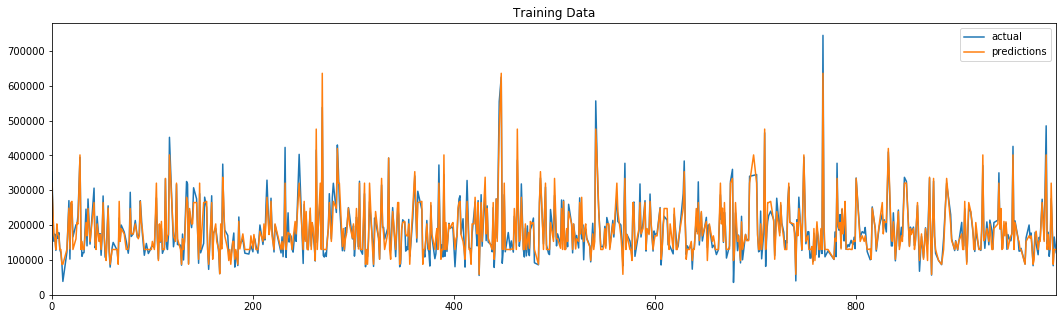

In [230]:
create_plot(train_df, tree, title="Training Data")

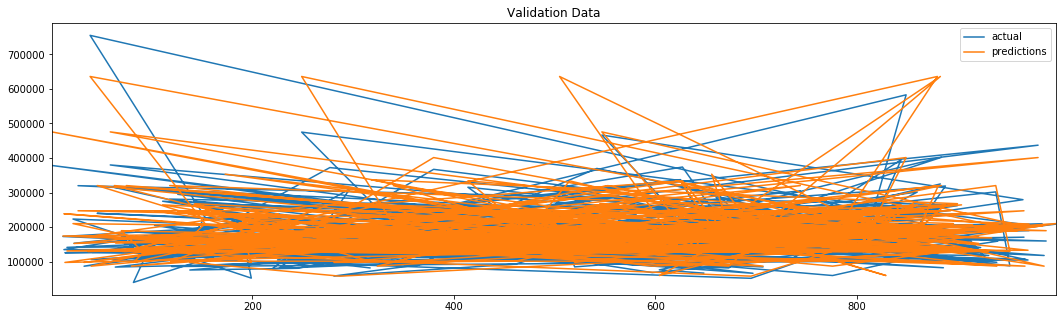

In [228]:
create_plot(valid_df, tree, title="Validation Data")

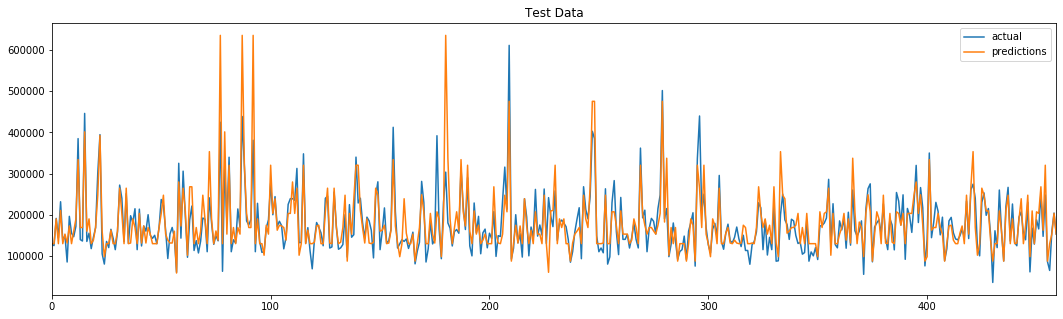

In [231]:
create_plot(test_df, tree, title="Test Data")